# Assess cultural affiliation in reddit loanword users
Let's assume that the following aspects of culture that are interesting to internet users:
- music
- television/film
- sports

Let's also assume that the internet users express their affiliation with these aspects of culture through discussion in topic-specific groups.

We therefore assess the level of affiliation to specific cultural sources of media based on (1) subreddit subscriptions and (2) entity mentions.

## Load data
We will access the data available on an Elasticsearch cluster. Details [here](https://github.gatech.edu/CompLingLab/RedditCommentDataset).

To set up cluster:
```
cd /hg190/elastic_search/es_instances_for_reddit_comments/2018/jan-june-2018/elasticsearch-2.1.1/bin/
./elasticsearch --cluster.name reddit_comments --node.name reddit_comments_2018_m_1_6 --Xmx 50g --Xms 50g
```

In [4]:
integrated_loanword_verbs = [l.strip() for l in open('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs.txt')]
print(len(integrated_loanword_verbs))

1345


## Collect seed targets
Let's look first at subreddits that are likely to have high cultural affinity with Latino media.

We will collect frequently-posting users in these subreddits, collect the subreddits to which those people post, and examine the most frequent cross-posted subreddits.

In [14]:
# seed_en_subreddits = ['whitepeopletwitter', 'news', 'politics', 'askanamerican', 'murica']
# seed_es_subreddits = ['latinopeopletwitter', 'hispanic', 'latinos', 'asklatinamerica', 'es']
# seed_en_sports_subreddits = ['hammers', 'ussoccer', 'liverpoolfc', 'chelseafc', 'mcfc']
# seed_es_sports_subreddits = ['ligamx', 'barca', 'realmadrid', 'fcf', 'valenciacf']
# TODO: geographic subreddits?
# music subredits
seed_es_subreddits = ['reggaeton', 'tango', 'salsa', 'dancehall', 'musicaenespanol']
seed_en_subreddits = ['popheads', 'hiphopheads', 'rap', 'jazz', 'punk']
seed_subreddit_set = set(seed_es_subreddits) | set(seed_en_subreddits)

In [58]:
import os
import re
data_dir = '/hg190/corpora/reddit_full_comment_data/2018/'
file_matcher = re.compile('RC_.*\.(zst|xz)')
data_files = list(filter(lambda x: file_matcher.search(x) is not None, os.listdir(data_dir)))
data_files = list(map(lambda x: os.path.join(data_dir, x), data_files))
print(data_files)
# tmp debugging
# data_files = data_files[:1]

['/hg190/corpora/reddit_full_comment_data/2018/RC_2018-02.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-03.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-04.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-05.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-06.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-07.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-08.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-09.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-10.xz', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-11.zst', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-12.zst', '/hg190/corpora/reddit_full_comment_data/2018/RC_2018-01.xz']


In [ ]:
%%capture sub_author_counts
# TODO: parallel?? dangerous in a notebook
import json
from data_helpers import get_file_iter
from collections import defaultdict
# tmp debugging
line_cutoff = 1000000
subreddit_author_counts = defaultdict(int)
line_ctr = 0
for data_file in data_files:
    print('processing file %s'%(data_file))
    file_iter = get_file_iter(data_file)
    for lines in file_iter:
        if(type(lines) is not list):
            lines = [lines]
        for line in lines:
            try:
                l_data = json.loads(line)
                l_sub = l_data['subreddit'].lower()
                l_author = l_data['author']
                if(l_sub in seed_subreddit_set):
                    subreddit_author_counts[(l_sub, l_author)] += 1
                    line_ctr += 1
                    if(line_ctr % 100000 == 0):
                        print('processed %d lines'%(line_ctr))
            except Exception as e:
                pass
#         if(line_ctr >= line_cutoff):
#             break
#     if(line_ctr >= line_cutoff):
#         break

In [61]:
sub_author_counts.show()

processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-02.xz
processed 100000 lines
processed 200000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-03.xz
processed 300000 lines
processed 400000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-04.xz
processed 500000 lines
processed 600000 lines
processed 700000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-05.xz
processed 800000 lines
processed 900000 lines
processed 1000000 lines
processed 1100000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-06.xz
processed 1200000 lines
processed 1300000 lines
processed 1400000 lines
processed 1500000 lines
processed 1600000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-07.xz
processed 1700000 lines
processed 1800000 lines
processed 1900000 lines
processing file /hg190/corpora/reddit_full_comment_data/2018/RC_2018-08.xz
processed 2000000 lines
proc

In [81]:
import pandas as pd
seed_subreddit_author_counts_data = pd.Series(subreddit_author_counts)
seed_subreddit_author_counts_data = seed_subreddit_author_counts_data.reset_index().rename(columns={'level_0' : 'subreddit', 'level_1' : 'author', 0 : 'count'})
# get rid of [deleted] and mod comments
ignore_authors = ['[deleted]', 'AutoModerator']
seed_subreddit_author_counts_data = seed_subreddit_author_counts_data[~seed_subreddit_author_counts_data.loc[:, 'author'].isin(ignore_authors)]

In [82]:
display(seed_subreddit_author_counts_data.head())

,subreddit,author,count
0,hiphopheads,jarizzle151,82
1,hiphopheads,thegreatbobin0_,26
2,hiphopheads,TheNoKarmaComment,572
3,hiphopheads,cthululover813,16
4,popheads,Joebiekong,2358


In [83]:
display(seed_subreddit_author_counts_data.loc[:, 'subreddit'].value_counts())

hiphopheads        170303
popheads            21930
jazz                12103
punk                10389
rap                  8034
salsa                 600
reggaeton             394
dancehall             185
tango                 161
musicaenespanol        61
Name: subreddit, dtype: int64

In [84]:
for subreddit_i, data_i in seed_subreddit_author_counts_data.groupby('subreddit'):
    data_i.sort_values('count', inplace=True, ascending=False)
    display(data_i.head(10))

/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,subreddit,author,count
56842,dancehall,luparo,205
37427,dancehall,tonynjeninfl,32
154158,dancehall,Realgmuzic,13
59617,dancehall,stalawa,9
8649,dancehall,Ghenges,9
93278,dancehall,Erotic_Ent,9
1195,dancehall,MountainEmperor,8
206575,dancehall,KellyIndo,7
183447,dancehall,DragunzDen,7
58246,dancehall,SwadeDaVillain,7


,subreddit,author,count
1575,hiphopheads,dadouks,15769
57,hiphopheads,rosey-the-bot,15106
205,hiphopheads,TheRoyalGodfrey,9784
1838,hiphopheads,Str8butboysrsexy,7852
1759,hiphopheads,codeine_turtle,7483
2391,hiphopheads,AmericanHerstoryX,6743
1486,hiphopheads,dakkadakka3,5946
2561,hiphopheads,TheInfinityGauntlet,5330
113,hiphopheads,nd20,5103
66741,hiphopheads,watashiwameron,5042


,subreddit,author,count
1082,jazz,xooxanthellae,2143
9147,jazz,smileymn,1087
918,jazz,Jon-A,807
2275,jazz,realanceps,676
173,jazz,fiveminutedoctor,652
11154,jazz,jazzadelic,539
1123,jazz,TimDamnit,486
953,jazz,Lemwell,476
6090,jazz,rosey-the-bot,397
2046,jazz,flare2000x,338


,subreddit,author,count
77429,musicaenespanol,Saturdizzle,14
89629,musicaenespanol,No1_Knows_Its_Me,12
106957,musicaenespanol,malilla,5
103479,musicaenespanol,timy2loose,4
178219,musicaenespanol,pepisrocha,4
177801,musicaenespanol,incognito42216,3
89736,musicaenespanol,pmdelgado2,3
107309,musicaenespanol,surreal_blue,3
115060,musicaenespanol,colegio_valentini,2
95279,musicaenespanol,lll__________lll,2


,subreddit,author,count
189,popheads,sapphire1921,8732
215,popheads,McIgglyTuffMuffin,4811
800,popheads,Belle-ET-La-Bete,4567
267,popheads,Piccprincess,4385
193,popheads,LittlestCandle,4191
261,popheads,joshually,3905
977,popheads,fifthchevron,3756
96,popheads,Ghost-Quartet,3172
219,popheads,WhatAGayTwist,3124
806,popheads,137288,2823


,subreddit,author,count
585,punk,J-Hx,1721
174,punk,rosey-the-bot,1487
551,punk,lieutenant_cthulhu,952
5254,punk,chrisdramapfaff,804
203,punk,xjoeymillerx,725
7802,punk,Pinguino2323,703
1314,punk,inmyeyes32,657
1546,punk,Iwasateenagebozo,646
6239,punk,iq_32,629
2906,punk,ObesityIsAMyth,619


,subreddit,author,count
147113,rap,Listige,316
70843,rap,ibbysquish,278
87539,rap,16yearoldwritingrap,239
270,rap,TonyTorzido,153
11559,rap,TheRealAdubz,136
5397,rap,PECOSbravo,125
128090,rap,maylertade30,117
44550,rap,KlixPlays,108
1445,rap,Glordicus,107
214,rap,atreddit13,106


,subreddit,author,count
25179,reggaeton,Taco_McBean,65
17825,reggaeton,GotDembow,52
14853,reggaeton,DildoMcHomie,30
139202,reggaeton,Salo_DL,29
115382,reggaeton,Chulito7,27
32674,reggaeton,JoseCFM,21
144708,reggaeton,Rickythetricky,16
91059,reggaeton,younowhyimhere,14
95308,reggaeton,CbProdz,13
200272,reggaeton,djtacubano,12


,subreddit,author,count
2177,salsa,double-you,279
42179,salsa,gumercindo1959,241
18614,salsa,bycdiaz,148
18603,salsa,LordofthePandas,95
5206,salsa,dwkfym,80
7257,salsa,plausiblycredulous,79
11084,salsa,andrewingram,76
13475,salsa,GetGirlNextDoor,71
137215,salsa,LastDanz,63
64937,salsa,Arshia42,54


,subreddit,author,count
3095,tango,mamborambo,60
10600,tango,indigo-alien,43
11100,tango,readmyebooks,43
51235,tango,Sudain,36
1714,tango,MisterMallet,34
5023,tango,pezthepezpez,31
38375,tango,magokaiser,25
57394,tango,olverine,24
2553,tango,bojerkenshire,24
204511,tango,Elviejopancho,23


Let's take the top-k authors from each subreddit and re-query the data to find their cross-posting habits.

In [86]:
top_k = 10
seed_subreddit_top_k_authors = []
for subreddit_i, data_i in seed_subreddit_author_counts_data.groupby('subreddit'):
    authors_i = data_i.sort_values('count', inplace=False, ascending=False).loc[:, 'author'].iloc[:top_k]
    seed_subreddit_top_k_authors += list(authors_i)

In [87]:
len(seed_subreddit_top_k_authors)

100

In [ ]:
%%capture seed_author_expand_counts
import json
from data_helpers import get_file_iter
from collections import defaultdict
# tmp debugging
line_cutoff = 1000000
seed_author_subreddit_counts = defaultdict(int)
line_ctr = 0
for data_file in data_files:
    print('processing file %s'%(data_file))
    file_iter = get_file_iter(data_file)
    for lines in file_iter:
        if(type(lines) is not list):
            lines = [lines]
        for line in lines:
            try:
                l_data = json.loads(line)
                l_sub = l_data['subreddit'].lower()
                l_author = l_data['author']
                if(l_author in seed_subreddit_top_k_authors):
                    seed_author_subreddit_counts[(l_sub, l_author)] += 1
                    line_ctr += 1
                    if(line_ctr % 100000 == 0):
                        print('processed %d lines'%(line_ctr))
            except Exception as e:
                pass
        if(line_ctr >= line_cutoff):
            break
    if(line_ctr >= line_cutoff):
        break

In [ ]:
print('done')

In [ ]:
import pandas as pd
seed_author_subreddit_counts_data = pd.Series(seed_author_subreddit_counts)
seed_author_subreddit_counts_data = seed_author_subreddit_counts_data.reset_index().rename(columns={'level_0' : 'subreddit', 'level_1' : 'author', 0 : 'count'})
# get rid of [deleted] and mod comments
ignore_authors = ['[deleted]', 'AutoModerator']
seed_author_subreddit_counts_data = seed_author_subreddit_counts_data[~seed_author_subreddit_counts_data.loc[:, 'author'].isin(ignore_authors)]
display(seed_author_subreddit_counts_data.head())

### Identify targets from language-specific subreddits
Let's get the overall counts of languages per subreddit and identify subreddits with high `ES` and high `EN` proportions [here](count_posts_per_lang_per_subreddit.py).

In [143]:
import pandas as pd
import re
import os
subreddit_lang_count_dir = '../../data/mined_reddit_comments/'
subreddit_lang_count_file_matcher = re.compile('RC_201[89]-.*_subreddit_lang_counts.tsv')
subreddit_lang_count_files = list(filter(lambda x: subreddit_lang_count_file_matcher.search(x) is not None, os.listdir(subreddit_lang_count_dir)))
print(subreddit_lang_count_files)
subreddit_lang_counts = [pd.read_csv(os.path.join(subreddit_lang_count_dir, f), sep='\t', index_col=0) for f in subreddit_lang_count_files]

['RC_2018-01_subreddit_lang_counts.tsv', 'RC_2018-02_subreddit_lang_counts.tsv', 'RC_2018-03_subreddit_lang_counts.tsv', 'RC_2018-04_subreddit_lang_counts.tsv', 'RC_2018-05_subreddit_lang_counts.tsv', 'RC_2018-06_subreddit_lang_counts.tsv', 'RC_2018-11_subreddit_lang_counts.tsv', 'RC_2018-12_subreddit_lang_counts.tsv', 'RC_2018-07_subreddit_lang_counts.tsv', 'RC_2018-08_subreddit_lang_counts.tsv', 'RC_2018-09_subreddit_lang_counts.tsv', 'RC_2018-10_subreddit_lang_counts.tsv', 'RC_2019-02_subreddit_lang_counts.tsv', 'RC_2019-01_subreddit_lang_counts.tsv', 'RC_2019-03_subreddit_lang_counts.tsv', 'RC_2019-04_subreddit_lang_counts.tsv', 'RC_2019-05_subreddit_lang_counts.tsv']


In [ ]:
import re
from functools import reduce
subreddit_lang_counts_combined = reduce(lambda x,y: x.add(y, fill_value=0), subreddit_lang_counts).fillna(0)
subreddit_lang_counts_combined.fillna(0, inplace=True)
subreddit_lang_counts_sum = subreddit_lang_counts_combined.sum(axis=1)
# remove users??
user_matcher = re.compile('^u_')
valid_subredit_idx = list(filter(lambda x: user_matcher.search(x) is None, subreddit_lang_counts_combined.index))
subreddit_lang_counts_combined = subreddit_lang_counts_combined.loc[valid_subredit_idx, :]
display(subreddit_lang_counts_combined.head())

In [146]:
display(subreddit_lang_counts_sum.sort_values(inplace=False, ascending=False).head())

subreddit
AskReddit     94380558.0
politics      32560799.0
nba           19332315.0
funny         14696296.0
The_Donald    14605583.0
dtype: float64

In [147]:
# normalize
subreddit_lang_pct = subreddit_lang_counts_combined.apply(lambda x: x / x.sum(), axis=1)
display(subreddit_lang_pct.head())

,af,ar,az,be,bg,bh,bn,bs,ca,ceb,...,xx-Tavt,xx-Tfng,xx-Ugar,xx-Vaii,xx-Xpeo,xx-Xsux,xx-Yiii,yi,zh,zh-Hant
subreddit,,,,,,,,,,,,,,,,,,,,,
00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000800991021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0010110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011110000110011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
top_k = 20
langs = ['es', 'en']
for lang in langs:
    print('lang=%s'%(lang))
    lang_pct_i = subreddit_lang_pct.loc[:, lang]
    lang_pct_i = lang_pct_i.sort_values(inplace=False, ascending=False)
    display(lang_pct_i.head(top_k))

lang=es


subreddit
TenkabitoonF2P        1.0
pyromide              1.0
monetarypolicy        1.0
PoliticaDeMexico      1.0
UltrapointEspanol     1.0
tjbttvpresentacion    1.0
memeball              1.0
ZepPosting            1.0
citytour              1.0
bookten               1.0
UltraConservative     1.0
Jaen                  1.0
VaquerosDeDallas      1.0
Chistes_Y_Humor       1.0
JagaJazzist           1.0
ChistesNegros         1.0
eegh                  1.0
dota2colombia         1.0
musicacristiana       1.0
qdance                1.0
Name: es, dtype: float64

lang=en


subreddit
SteamPowerMachineShop    1.0
Traha                    1.0
TraidPlatform            1.0
TrailAnimals             1.0
TrailBC                  1.0
TrailTrash               1.0
TrailerBuild             1.0
TrailerEdits             1.0
TrailerParkBoysOG        1.0
TrailerParkHacks         1.0
TrailerTrash             1.0
TrailerTrashin           1.0
Trailerreactions         1.0
TrainArt                 1.0
TrainCrew                1.0
TrainToBeRP              1.0
TrainVideos              1.0
TrainerAMA               1.0
TrainingForYou           1.0
TrainingManual           1.0
Name: en, dtype: float64

OK! How many of these match our frequency threshold?

Let's say that a subreddit should have at least N comments per month.

In [149]:
min_comments_per_month = 5
comments_per_year = 12 * min_comments_per_month
subreddit_lang_counts_sum_cutoff = subreddit_lang_counts_sum[subreddit_lang_counts_sum >= comments_per_year]
print('%d/%d subreddits with high comments'%(subreddit_lang_counts_sum_cutoff.shape[0], subreddit_lang_counts_sum.shape[0]))

78898/592172 subreddits with high comments


In [150]:
# top subreddits per lang
top_k = 20
langs = ['es', 'en']
for lang in langs:
    lang_pct_i = subreddit_lang_pct.loc[subreddit_lang_counts_sum_cutoff.index, lang]
    lang_pct_i = lang_pct_i[lang_pct_i > 0.]
    print('lang=%s, %d subreddits'%(lang, len(lang_pct_i)))
    lang_pct_i = lang_pct_i.sort_values(inplace=False, ascending=False)
    display(lang_pct_i.head(top_k))

lang=es, 15202 subreddits


/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


subreddit
etesuntest              0.984000
EcuadorNoticias         0.962610
CineClub                0.959596
FacturaElectronicaCR    0.955357
escribir                0.936170
aguascalientes          0.932773
ultimex                 0.932432
MGTOW_es                0.921875
filosofia_en_espanol    0.917526
FFBraveExviusES         0.913793
ArAutos                 0.908852
merval                  0.903926
DerechoGenial           0.901834
FitnessArgentina        0.898699
CABocaJuniors           0.878151
feministas              0.875598
VisualTime              0.873016
ClubdelecturaChile      0.863366
Miedo                   0.862069
podemos                 0.859735
Name: es, dtype: float64

lang=en, 72741 subreddits


subreddit
deadlifting              1.0
AestheticTestArea        1.0
ManUnitedRealMadrid      1.0
rcrimescene              1.0
ChicagoBike              1.0
lymephotos               1.0
sp0rts2live              1.0
FeynmansAcademy          1.0
sp0rts_tv                1.0
COWBOYE                  1.0
AllTurtles               1.0
HentaiHand               1.0
BandInstrumentRepair     1.0
ShingekiNoRenaissance    1.0
CPLT2202_ENGL2202        1.0
WorldFailures101         1.0
erojapanese              1.0
sp0rtlive                1.0
TheValisani              1.0
ManaSpark                1.0
Name: en, dtype: float64

OK! Let's do a first pass and look for music-related subreddits.

### Filter, pair language-specific subreddits

In [151]:
# top subreddits per lang
top_k = 20
langs = ['es', 'en']
for lang in langs:
    lang_pct_i = subreddit_lang_pct.loc[subreddit_lang_counts_sum_cutoff.index, lang]
    lang_pct_i = lang_pct_i[lang_pct_i > 0.5]
    print('lang=%s, %d subreddits'%(lang, len(lang_pct_i)))
    lang_pct_i = lang_pct_i.sort_values(inplace=False, ascending=False)
    print('\n'.join(lang_pct_i.index))

lang=es, 140 subreddits
etesuntest
EcuadorNoticias
CineClub
FacturaElectronicaCR
escribir
aguascalientes
ultimex
MGTOW_es
filosofia_en_espanol
FFBraveExviusES
ArAutos
merval
DerechoGenial
FitnessArgentina
CABocaJuniors
feministas
VisualTime
ClubdelecturaChile
Miedo
podemos
AskArgentina
pesquisasmormonas
LGBT_de_Argentina
NoFapES
Tecnologia
DerechoMexicano
Cordoba
ArgEntos
Argaming
RolEnEspanol
ArgentinaCocina
LibertariosArgentina
metalero
fulbo
Republica_Argentina
CryptoMexico
POLACA
RepublicaArgentina
Devmexico
Extj
SpainFIRE
switchfansargentina
CARiverPlate
programacion
es
Rosario
clubdelectura
pizzelpodcast
XWingFightersPeru
4toy7moArte
CryptoChile
Veganismo
espelufrio
videojuego
Monterrey
Despertar
LaPepaRoja
jmVaper
libros
Argentinados
argentina
notArgentina
uruguay
Mercadoreddit
mexico
videojuegos
SpanishBookClub
deisi
GNULinuxEsp
chile
FeminismoRadical
empleos_AR
ArgenBitcoin
pitcnt
CriptoMonedas
ROU
redditores
DungeonsAndPaths
Wallmapu
GayBrosPreguntan
retrasosquad
ArgentinaBen

In [153]:
es_dominant_culture_subreddits = ['metalero', 'fulbo', 'videojuegos', 'Veganismo', 'Argaming', 'Blasfemia', 'CriptoMonedas', 'TinderEs', 'escribir', 'Tecnologia', 'programacion', 'Bitcoin_espanol', 'MusicaEnEspanol']
en_dominant_culture_subreddits = ['metal', 'soccer', 'videogames', 'vegan', 'gaming', 'blasphemy', 'cryptocurrency', 'tinder', 'writing', 'technology', 'programming', 'bitcoin', 'music']

In [154]:
for es_sub, en_sub in zip(es_dominant_culture_subreddits, en_dominant_culture_subreddits):
    print('%s,%s'%(es_sub, en_sub))

metalero,metal
fulbo,soccer
videojuegos,videogames
Veganismo,vegan
Argaming,gaming
Blasfemia,blasphemy
CriptoMonedas,cryptocurrency
TinderEs,tinder
escribir,writing
Tecnologia,technology
programacion,programming
Bitcoin_espanol,bitcoin
MusicaEnEspanol,music


To start, let's get the high-`ES` subreddits and pair each one with a high-`EN` subreddit with roughly the same posting activity.

In [152]:
lang_pct_es = subreddit_lang_pct.loc[subreddit_lang_counts_sum_cutoff.index, 'es']
lang_pct_en = subreddit_lang_pct.loc[subreddit_lang_counts_sum_cutoff.index, 'en']
lang_pct_es = lang_pct_es[lang_pct_es > 0.5]
lang_pct_en = lang_pct_en[lang_pct_en > 0.5]
subreddit_lang_counts_sum_en = subreddit_lang_counts_sum.loc[lang_pct_en.index]
subreddit_lang_counts_sum_es = subreddit_lang_counts_sum.loc[lang_pct_es.index]
subreddit_lang_counts_sum_es.sort_values(inplace=True, ascending=False)
lang_pct_es = lang_pct_es.loc[subreddit_lang_counts_sum_es.index]
for es_subreddit_i in lang_pct_es.index:
    sum_i = subreddit_lang_counts_sum_es.loc[es_subreddit_i]
    en_subreddit_i = (abs(subreddit_lang_counts_sum_en - sum_i)).sort_values(inplace=False, ascending=True).index[0]
    print('ES = %s (N=%d), EN = %s (N=%d)'%(es_subreddit_i, sum_i, en_subreddit_i, subreddit_lang_counts_sum_en.loc[en_subreddit_i]))

ES = argentina (N=1725644), EN = CasualUK (N=1726105)
ES = mexico (N=874485), EN = PurplePillDebate (N=874693)
ES = chile (N=407873), EN = drunk (N=408378)
ES = vzla (N=271338), EN = AskALiberal (N=271502)
ES = uruguay (N=206873), EN = TeamSolomid (N=207019)
ES = podemos (N=137668), EN = Pokemongiveaway (N=137516)
ES = spain (N=96833), EN = learnart (N=96782)
ES = RepublicaArgentina (N=89005), EN = wifepictrading (N=89017)
ES = EcuadorNoticias (N=20460), EN = earrumblersassemble (N=20462)
ES = PERU (N=19779), EN = doggos (N=19781)
ES = Argaming (N=19419), EN = WarhammerUnderworlds (N=19418)
ES = ArgentinaBenderStyle (N=18474), EN = GripTraining (N=18473)
ES = Monterrey (N=16932), EN = XSomalian (N=16931)
ES = es (N=10444), EN = asaprocky (N=10443)
ES = Mujico (N=8326), EN = hentaibondage (N=8325)
ES = ArgEntos (N=6163), EN = glee (N=6162)
ES = CARiverPlate (N=6148), EN = papertowns (N=6149)
ES = Mercadoreddit (N=5333), EN = Hostworld (N=5332)
ES = Yointerneto (N=5160), EN = 3gun (N=515

OK! It seems like the "match" `EN` subreddits have very different topics as compared to the original `ES` subreddits.

Can we control for this? We would have to translate all `ES` words to `EN` and then match subreddits based on similar TF-IDF profiles.

Maybe an easier way to do this is with a bootstrap.
Assign a new random `EN` subreddit match based on roughly the same comment volume (round to nearest 100?), then compare the relative dependent variable rates across matches.

### Test loanword coverage in reddit ES instances
Before doing anything, let's find the total number of integrated/non-integrated loanwords in 2018 reddit.

In [669]:
import re
import pandas as pd
from functools import reduce
integrated_verb_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_integrated_verbs_query_phrases.tsv', sep='\t', index_col=False)
paren_matcher = re.compile('(?<=\()[^\)]+(?=\))')
integrated_verb_data = integrated_verb_data.assign(**{
    'verb_list' : integrated_verb_data.loc[:, 'verb'].apply(lambda x: paren_matcher.search(x).group(0).split('|'))
})
# flatten
integrated_verb_data_flat = pd.DataFrame(list(reduce(lambda x,y: x+y, integrated_verb_data.loc[:, ['loanword', 'verb_list']].apply(lambda x: list(zip((x[0],)*len(x[1]), x[1])), axis=1))))
display(integrated_verb_data_flat.head())

,0,1
0,access,accesé
1,access,accesamos
2,access,accesaste
3,access,accesasteis
4,access,accesó


In [ ]:
import subprocess
import os
from time import sleep
from elasticsearch.helpers import scan
months = ['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec']
es_year_month_pairs = [(2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
# es_instances = ['reddit_comments_2018_m_7_9', 'reddit_comments_2018_m_10_12', 'reddit_comments_2019_m_1_3', 'reddit_comments_2019_m_4_6']
es_cluster_name = 'reddit_comments'
es_dir = '/hg190/elastic_search/es_instances_for_reddit_comments/'
ES_INITIALIZE_TIMEOUT = 300
MAX_QUERY_SIZE=1000
loanword_verb_counts = []
for es_year, es_start_month, es_end_month in es_year_month_pairs:
    es_instance_name = '%s_%d_m_%d_%d'%(es_cluster_name, es_year, es_start_month, es_end_month)
    es_start_month_str = months[es_start_month-1]
    es_end_month_str = months[es_end_month-1]
    es_dir_full = os.path.join(es_dir, str(es_year), '%s-%s-%d'%(es_start_month_str, es_end_month_str, es_year), 'elasticsearch-2.1.1/bin')
    print(es_dir_full)
    # start up ES
    es_command = './elasticsearch --cluster.name %s --node.name %s'%(es_cluster_name, es_instance_name)
    process = subprocess.Popen(es_command.split(' '), cwd=es_dir_full)
    try:
        sleep(ES_INITIALIZE_TIMEOUT)
    except Exception as e:
        pass
    es = Elasticsearch(timeout=ES_INITIALIZE_TIMEOUT)
    # test query
    for loanword, loanword_verbs in integrated_verb_data.loc[:, ['loanword', 'verb_list']].values:
        for loanword_verb in loanword_verbs:
            es_query = {
                "query" : {
                    "bool" : {
                        # one-word match
                        "must" : [
                            {
                                "match" : {
                                    "body" : loanword_verb,
                                }
                            },
                            {
                                "match" : {
                                    "lang" : "es"
                                }
                            }
                        ],
                    }
                }
            }
            # search: returns all hits ;_; too heavy
#             loanword_verb_res = es.search(index=es_instance_name, body=es_query, size=10000)
            # scan: iterates through hits
            loanword_verb_res = es.search(index=es_instance_name, body=es_query, size=MAX_QUERY_SIZE, scroll='2m')
            scroll_id = loanword_noun_res['_scroll_id']
            scroll_size = len(loanword_noun_res['hits']['hits'])
            loanword_verb_hits = 0
            while(scroll_size > 0):
                loanword_verb_hits += len(loanword_noun_res['hits']['hits'])
                loanword_verb_res = es.scroll(scroll_id=scroll_id, scroll='2m')
                scroll_id = loanword_verb_res['_scroll_id']
                scroll_size = len(loanword_verb_res['hits']['hits'])
#         print('%d hits'%(len(res['hits']['hits'])))
            loanword_verb_hits = len(loanword_verb_res['hits']['hits'])
            loanword_verb_counts.append([loanword, loanword_verb, loanword_verb_hits, es_year, es_start_month, es_end_month])
        
    print('finished index %s'%(es_instance_name))
    process.terminate()
loanword_verb_counts_data = pd.DataFrame(loanword_verb_counts, names=['loanword', 'verb', 'hits', 'year', 'start_month', 'end_month'])

/hg190/elastic_search/es_instances_for_reddit_comments/2018/july-sep-2018/elasticsearch-2.1.1/bin


In [676]:
loanword_verb_counts_data = pd.DataFrame(loanword_verb_counts, columns=['loanword', 'verb', 'hits', 'year', 'start_month', 'end_month'])

In [677]:
display(loanword_verb_counts_data)

,loanword,verb,hits,year,start_month,end_month
0,access,accesé,0,2018,7,9
1,access,accesamos,0,2018,7,9
2,access,accesaste,0,2018,7,9
3,access,accesasteis,0,2018,7,9
4,access,accesó,0,2018,7,9
...,...,...,...,...,...,...
4707,zap,zapearás,0,2018,10,12
4708,zap,zapearéis,0,2018,10,12
4709,zap,zapeará,0,2018,10,12
4710,zap,zapearán,0,2018,10,12


In [679]:
# get totals
loanword_verb_counts_data = pd.DataFrame(loanword_verb_counts, columns=['loanword', 'verb', 'hits', 'year', 'start_month', 'end_month'])
loanword_verb_count_totals = loanword_verb_counts_data.groupby('verb').apply(lambda x: x.loc[:, 'hits'].sum()).sort_values(inplace=False, ascending=False)
loanword_verb_group_count_totals = loanword_verb_counts_data.groupby('loanword').apply(lambda x: x.loc[:, 'hits'].sum()).sort_values(inplace=False, ascending=False)
print('verb totals')
display(loanword_verb_count_totals.head(10))
print('loanword totals')
display(loanword_verb_group_count_totals.head(10))

verb totals


verb
acceso        2000
postear       1323
posteo         678
estándar       648
downvotean     566
conectar       560
googlear       465
pucha          458
postea         440
banearon       407
dtype: int64

loanword totals


loanword
post        3448
access      2029
connect     1376
downvote    1307
ban         1196
google       898
check        721
standard     652
push         652
flash        589
dtype: int64

How about light verbs? 

We have to query for (1) target noun (e.g. `tweet`) and then filter for (2) light verb phrase (`hacer (un) (tweet)`.

In [680]:
import re
import pandas as pd
light_verb_data = pd.read_csv('../../data/loanword_resources/wiktionary_twitter_reddit_loanword_verbs_light_verbs_query_phrases.tsv', sep='\t', index_col=False)
# collect nouns
noun_matcher = re.compile('([a-z\|]+)$|(?<=\()([a-z\-\|]+)(?=\)$)')
# for verb in light_verb_data.loc[:, 'verb']:
#     try:
#         noun = noun_matcher.search(verb).group(0)
#         print(noun)
#     except Exception as e:
#         print('verb=%s'%(verb))
light_verb_data = light_verb_data.assign(**{
    'nouns' : light_verb_data.loc[:, 'verb'].apply(lambda x: noun_matcher.search(x).group(0).split('|'))
})
display(light_verb_data.head())

,loanword,verb,nouns
0,access,(hice|hicimos|hiciste|hicisteis|hizo|hicieron|...,[acces]
1,aim,(hice|hicimos|hiciste|hicisteis|hizo|hicieron|...,[aim]
2,alert,(hice|hicimos|hiciste|hicisteis|hizo|hicieron|...,[alert]
3,audit,(hice|hicimos|hiciste|hicisteis|hizo|hicieron|...,[audit]
4,ban,(hice|hicimos|hiciste|hicisteis|hizo|hicieron|...,[ban]


In [682]:
from importlib import reload
import subprocess
import os
from time import sleep
import data_helpers
reload(data_helpers)
from data_helpers import clean_txt_for_matching
from elasticsearch.helpers import scan
months = ['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec']
es_year_month_pairs = [(2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
# es_instances = ['reddit_comments_2018_m_7_9', 'reddit_comments_2018_m_10_12', 'reddit_comments_2019_m_1_3', 'reddit_comments_2019_m_4_6']
es_cluster_name = 'reddit_comments'
es_dir = '/hg190/elastic_search/es_instances_for_reddit_comments/'
ES_INITIALIZE_TIMEOUT = 150
loanword_light_verb_counts = []
txt_var = 'body'
MAX_SIZE = 1000
for es_year, es_start_month, es_end_month in es_year_month_pairs:
    es_instance_name = '%s_%d_m_%d_%d'%(es_cluster_name, es_year, es_start_month, es_end_month)
    es_start_month_str = months[es_start_month-1]
    es_end_month_str = months[es_end_month-1]
    es_dir_full = os.path.join(es_dir, str(es_year), '%s-%s-%d'%(es_start_month_str, es_end_month_str, es_year), 'elasticsearch-2.1.1/bin')
    print('starting index %s'%(es_instance_name))
    # start up ES
    es_command = './elasticsearch --cluster.name %s --node.name %s'%(es_cluster_name, es_instance_name)
#     try:
    process = subprocess.Popen(es_command.split(' '), cwd=es_dir_full)
    try:
        sleep(ES_INITIALIZE_TIMEOUT)
    except Exception as e:
        pass
    es = Elasticsearch(timeout=100)
    # test query
    for loanword, light_verb_phrase, loanword_nouns in light_verb_data.loc[:, ['loanword', 'verb', 'nouns']].values:
        light_verb_phrase_matcher = re.compile(light_verb_phrase)
        for loanword_noun in loanword_nouns:
            print('noun = %s'%(loanword_noun))
            es_query = {
                "query" : {
                    "bool" : {
                        # one-word match
                        "must" : [
                            {
                                "match" : {
                                    "body" : loanword_noun,
                                }
                            },
                            {
                                "match" : {
                                    "lang" : "es"
                                }
                            }
                        ],
                    }
                    
                }
            }
            loanword_noun_res = es.search(index=es_instance_name, body=es_query, size=MAX_SIZE, scroll='2m')
            scroll_id = loanword_noun_res['_scroll_id']
            scroll_size = len(loanword_noun_res['hits']['hits'])
            loanword_noun_hits = 0
            loanword_light_verb_hits = 0
            while(scroll_size > 0):
                loanword_noun_hits += len(loanword_noun_res['hits']['hits'])
                for i, res_i in enumerate(loanword_noun_res['hits']['hits']):
                    res_i_txt = res_i['_source'][txt_var]
                    res_i_txt = clean_txt_for_matching(res_i_txt)
                    if(light_verb_phrase_matcher.search(res_i_txt) is not None):
                        loanword_light_verb_hits += 1
    #             loanword_noun_hits = len(loanword_noun_res['hits']['hits'])
                print('%d hits for %s'%(loanword_noun_hits, loanword_noun))
                loanword_noun_res = es.scroll(scroll_id=scroll_id, scroll='2m')
                scroll_id = loanword_noun_res['_scroll_id']
                scroll_size = len(loanword_noun_res['hits']['hits'])
            loanword_light_verb_counts.append([loanword, loanword_noun, loanword_noun_hits, loanword_light_verb_hits, es_year, es_start_month, es_end_month])
    print('finished index %s'%(es_instance_name))
    process.terminate()
#     except Exception as e:
#         print('exception = %s'%(e))
#         print('finished index %s'%(es_instance_name))
#         process.terminate()
#         break
loanword_light_verb_counts = pd.DataFrame(loanword_light_verb_counts, columns=['loanword', 'loanword_noun', 'loanword_hits', 'light_verb_hits', 'year', 'start_month', 'end_month'])

starting index reddit_comments_2018_m_7_9
noun = acces
1 hits for acces
noun = aim
10 hits for aim
noun = alert
94 hits for alert
noun = audit
2 hits for audit
noun = ban
418 hits for ban
noun = bang
61 hits for bang
noun = bash
13 hits for bash
noun = block
49 hits for block
noun = boicot
63 hits for boicot
noun = box
121 hits for box
noun = boxing
54 hits for boxing
noun = bully
41 hits for bully
noun = bust
7 hits for bust
noun = cast
23 hits for cast
noun = casting
28 hits for casting
noun = change
101 hits for change
noun = chat
329 hits for chat
noun = cheque
184 hits for cheque
noun = shot
45 hits for shot
noun = combat
20 hits for combat
noun = n
963 hits for n
noun = crack
269 hits for crack
noun = custom
46 hits for custom
noun = customized
noun = default
663 hits for default
noun = delete
27 hits for delete
noun = dm
179 hits for dm
noun = doping
24 hits for doping
noun = downvote
444 hits for downvote
noun = draft
9 hits for draft
noun = dren
2 hits for dren
noun = drible
n

1000 hits for sign-in
2000 hits for sign-in
2831 hits for sign-in
noun = signin
1 hits for signin
noun = stalker
28 hits for stalker
noun = strike
27 hits for strike
noun = surf
19 hits for surf
noun = tackle
7 hits for tackle
noun = text
104 hits for text
noun = tick
6 hits for tick
noun = torment
1 hits for torment
noun = touch
40 hits for touch
noun = transport
6 hits for transport
noun = travel
85 hits for travel
noun = trol
14 hits for trol
noun = tweet
287 hits for tweet
noun = twerk
4 hits for twerk
noun = upvote
603 hits for upvote
noun = vape
29 hits for vape
noun = vaping
9 hits for vaping
noun = zap
8 hits for zap
noun = zapping
25 hits for zapping
finished index reddit_comments_2018_m_10_12
starting index reddit_comments_2019_m_1_3
noun = acces
1 hits for acces
noun = aim
24 hits for aim
noun = alert
94 hits for alert
noun = audit
1 hits for audit
noun = ban
373 hits for ban
noun = bang
74 hits for bang
noun = bash
15 hits for bash
noun = block
50 hits for block
noun = boic

19 hits for rape
noun = recording
1 hits for recording
noun = remastered
2 hits for remastered
noun = render
18 hits for render
noun = rendered
noun = rental
3 hits for rental
noun = renting
1 hits for renting
noun = report
66 hits for report
noun = reset
28 hits for reset
noun = respect
25 hits for respect
noun = ring
35 hits for ring
noun = rock
399 hits for rock
noun = roll
49 hits for roll
noun = sample
6 hits for sample
noun = selfie
58 hits for selfie
noun = sext
noun = ship
4 hits for ship
noun = shitpost
119 hits for shitpost
noun = shock
186 hits for shock
noun = sign-in
1000 hits for sign-in
2000 hits for sign-in
2298 hits for sign-in
noun = signin
1 hits for signin
noun = stalker
20 hits for stalker
noun = strike
28 hits for strike
noun = surf
25 hits for surf
noun = tackle
2 hits for tackle
noun = text
71 hits for text
noun = tick
6 hits for tick
noun = torment
1 hits for torment
noun = touch
35 hits for touch
noun = transport
9 hits for transport
noun = travel
93 hits for 

These totals don't look big, but let's take a look anyway.

In [683]:
loanword_noun_count_totals = loanword_light_verb_counts.groupby('loanword').apply(lambda x: x.loc[:, 'loanword_hits'].sum()).sort_values(inplace=False, ascending=False)
loanword_light_verb_count_totals = loanword_light_verb_counts.groupby('loanword').apply(lambda x: x.loc[:, 'light_verb_hits'].sum()).sort_values(inplace=False, ascending=False)
print('noun count totals')
display(loanword_noun_count_totals.head(10))
print('light verb totals')
display(loanword_light_verb_count_totals.head(10))

noun count totals


loanword
post        22104
sign-in     11003
google       8537
link         8270
connect      3937
gentrify     3937
PM           3198
default      2628
rant         2370
like         2347
dtype: int64

light verb totals


loanword
post        1111
google       467
upvote       398
PM           334
downvote     301
link         223
like         169
rant          56
pan           28
zap           27
dtype: int64

These numbers are kinda small but hopefully the author population has sufficient diversity to warrant analysis.

Let's get the sets of integrated verb authors and light verb authors.

In [ ]:
%%capture es_query_output
import data_helpers
from importlib import reload
reload(data_helpers)
from data_helpers import collect_scroll_results
months = ['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec']
es_year_month_pairs = [(2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
es_cluster_name = 'reddit_comments'
es_dir = '/hg190/elastic_search/es_instances_for_reddit_comments/'
ES_INITIALIZE_TIMEOUT = 150
txt_var = 'body'
author_var = 'author'
subreddit_var = 'subreddit'
MAX_SIZE = 1000
## collect author, subreddit names
loanword_integrated_verb_author_data = []
loanword_light_verb_author_data = []
for es_year, es_start_month, es_end_month in es_year_month_pairs:
    es_instance_name = '%s_%d_m_%d_%d'%(es_cluster_name, es_year, es_start_month, es_end_month)
    es_start_month_str = months[es_start_month-1]
    es_end_month_str = months[es_end_month-1]
    es_dir_full = os.path.join(es_dir, str(es_year), '%s-%s-%d'%(es_start_month_str, es_end_month_str, es_year), 'elasticsearch-2.1.1/bin')
    print('starting index %s'%(es_instance_name))
    # start up ES
    es_command = './elasticsearch --cluster.name %s --node.name %s'%(es_cluster_name, es_instance_name)
#     try:
    process = subprocess.Popen(es_command.split(' '), cwd=es_dir_full)
    try:
        sleep(ES_INITIALIZE_TIMEOUT)
    except Exception as e:
        pass
    es = Elasticsearch(timeout=100)
    ## integrated verbs
    for loanword, integrated_verb in integrated_verb_data_flat.values:
        es_query = {
            "query" : {
                "bool" : {
                    # one-word match
                    "must" : [
                        {
                            "match" : {
                                "body" : integrated_verb,
                            }
                        },
                        {
                            "match" : {
                                "lang" : "es"
                            }
                        }
                    ],
                }

            }
        }
#         loanword_verb_res = scan(es, index=es_instance_name, query=es_query)
        loanword_verb_res = collect_scroll_results(es, es_instance_name, es_query)
        for i, res_i in enumerate(loanword_verb_res):
            data_i = res_i['_source']
            loanword_integrated_verb_author_data.append([loanword, integrated_verb, data_i[author_var], data_i[subreddit_var]])
    ## light verbs
    for loanword, light_verb_phrase, loanword_nouns in light_verb_data.loc[:, ['loanword', 'verb', 'nouns']].values:
        light_verb_phrase_matcher = re.compile(light_verb_phrase)
        for loanword_noun in loanword_nouns:
            print('noun = %s'%(loanword_noun))
            es_query = {
                "query" : {
                    "bool" : {
                        # one-word match
                        "must" : [
                            {
                                "match" : {
                                    "body" : loanword_noun,
                                }
                            },
                            {
                                "match" : {
                                    "lang" : "es"
                                }
                            }
                        ],
                    }
                    
                }
            }
            loanword_light_verb_res = collect_scroll_results(es, es_instance_name, es_query)
            for i, res_i in enumerate(loanword_light_verb_res):
                data_i = res_i['_source']
                txt_i = clean_txt_for_matching(data_i[txt_var])
                light_verb_match_i = light_verb_phrase_matcher.search(txt_i)
                if(light_verb_match_i is not None):
                    light_verb_match_txt_i = light_verb_match_i.group(0)
                    loanword_light_verb_author_data.append([loanword, light_verb_match_txt_i, data_i[author_var], data_i[subreddit_var]])
    print('finished index %s'%(es_instance_name))
    process.terminate()
#     except Exception as e:
#         print('exception = %s'%(e))
#         print('finished index %s'%(es_instance_name))
#         process.terminate()
#         break
loanword_integrated_verb_author_data = pd.DataFrame(loanword_integrated_verb_author_data, columns=['loanword', 'verb', 'author', 'subreddit'])
loanword_light_verb_author_data = pd.DataFrame(loanword_light_verb_author_data, columns=['loanword', 'verb', 'author', 'subreddit'])

In [686]:
display(loanword_integrated_verb_author_data.head())
display(loanword_light_verb_author_data.head())

,loanword,verb,author,subreddit
0,access,acceso,msx,italy
1,access,acceso,pokerissimo,italy
2,access,acceso,Ze120,mexico
3,access,acceso,Kablo,argentina
4,access,acceso,R3PTILIA,chile


,loanword,verb,author,subreddit
0,bang,hace bang,jacobgreen__,FortNiteBR
1,bang,hace bang,IWannaREEEEEEEEEEEEE,uwaterloo
2,bang,hace bang,CummyBot2000,copypasta
3,bang,hace bang,ScampiCat,btd6
4,bash,das bash,Ms203040,mexico


Sanity check: what are the most common subreddits for both sets?

In [688]:
display(loanword_integrated_verb_author_data.loc[:, 'subreddit'].value_counts().head(10))
display(loanword_light_verb_author_data.loc[:, 'subreddit'].value_counts().head(10))

argentina             16310
mexico                 4436
chile                  4247
vzla                   2217
uruguay                1930
RepublicaArgentina     1784
EcuadorNoticias        1590
podemos                 745
spain                   630
Argaming                288
Name: subreddit, dtype: int64

argentina             1275
mexico                 468
chile                  294
uruguay                268
vzla                   263
RepublicaArgentina      97
SquarePosting           80
spain                   66
podemos                 48
PERU                    35
Name: subreddit, dtype: int64

OK! Most instances of loanwords and light verbs happen in Latin American subreddits - no surprise there.

### Collect author post history

For each author, let's find their post history and determine if they tend to post in ES-dominant or EN-dominant subreddits.

In [689]:
loanword_author_set = list(set(loanword_integrated_verb_author_data.loc[:, 'author'].unique()) | set(loanword_light_verb_author_data.loc[:, 'author'].unique()))
print(len(loanword_author_set))

9820


In [690]:
def execute_queries_all_instances(es_queries):
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec']
    es_year_month_pairs = [(2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
    es_cluster_name = 'reddit_comments'
    es_dir = '/hg190/elastic_search/es_instances_for_reddit_comments/'
    ES_INITIALIZE_TIMEOUT = 150
    MAX_SIZE = 1000
    ## collect all results
    combined_results = []
    for es_year, es_start_month, es_end_month in es_year_month_pairs:
        es_instance_name = '%s_%d_m_%d_%d'%(es_cluster_name, es_year, es_start_month, es_end_month)
        es_start_month_str = months[es_start_month-1]
        es_end_month_str = months[es_end_month-1]
        es_dir_full = os.path.join(es_dir, str(es_year), '%s-%s-%d'%(es_start_month_str, es_end_month_str, es_year), 'elasticsearch-2.1.1/bin')
        print('starting index %s'%(es_instance_name))
        # start up ES
        es_command = './elasticsearch --cluster.name %s --node.name %s'%(es_cluster_name, es_instance_name)
    #     try:
        process = subprocess.Popen(es_command.split(' '), cwd=es_dir_full)
        try:
            sleep(ES_INITIALIZE_TIMEOUT)
        except Exception as e:
            pass
        es = Elasticsearch(timeout=100)
        # execute queries
        for es_query in es_queries:
            results = []
            res = collect_scroll_results(es, es_instance_name, es_query)
            for i, res_i in enumerate(res):
                results.append(res_i['_source'])
            combined_results.append(results)
        process.terminate()
    return combined_results

In [3]:
%%capture scroll_results
from math import ceil
from data_helpers import collect_scroll_results
MAX_CHUNK_SIZE=512
chunks = int(ceil(len(loanword_author_set) / MAX_CHUNK_SIZE))
author_subreddit_counts = []
loanword_author_es_en_queries = []
langs = ['en', 'es']
for lang in langs:
    for i in range(chunks):
        author_chunk = loanword_author_set[(i*MAX_CHUNK_SIZE):((i+1)*MAX_CHUNK_SIZE)]
    #     es_query = {
    #         "query" : {
    #             "bool" : {
    #                 # one-word match
    #                 "must" : [
    #                     {
    #                         "match" : {
    #                             "author" : "|".join(author_chunk),
    #                         }
    #                     },
    #                     {
    #                         "match" : {
    #                             "lang" : "es"
    #                         }
    #                     }
    #                 ],
    #             }
    #         }
    #     }
        query = {
            "query" : {
                "bool" : {
                    # one-word match
                    "must" : [
                        {
                            "match" : {
                                "author" : "|".join(author_chunk),
                            }
                        },
                        {
                            "match" : {
                                "lang" : lang
                            }
                        }
                    ],
                }
            }
        }
        loanword_author_es_en_queries.append(query)
loanword_author_query_results = execute_queries_all_instances(loanword_author_es_en_queries)

UsageError: Line magic function `%capture` not found (But cell magic `%%capture` exists, did you mean that instead?).


In [1]:
print('test')

test


In [2]:
loanword_author_query_author_subreddits = []
for query_result_list in loanword_author_query_results:
    loanword_author_query_author_subreddits += list(map(lambda x: [x['author'], x['subreddit'], x['lang']], query_result_list))
print(len(loanword_author_query_author_subreddits))
loanword_author_query_author_subreddits_data = pd.DataFrame(loanword_author_query_author_subreddits, columns=['author', 'subreddit', 'lang'])

NameError: name 'loanword_author_query_results' is not defined

In [694]:
# tmp save => let's not repeat this process!!
loanword_author_query_author_subreddits_data.to_csv('../../data/mined_reddit_comments/loanword_integrated_verb_light_verb_author_data_2018_2019.tsv', sep='\t', index=False)

Combine query results, get author/subreddit counts.

In [695]:
es_dominant_subreddits = list(map(lambda x: x.strip(), open('../../data/mined_reddit_comments/es_dominant_subreddits.txt')))
en_dominant_subreddits = list(map(lambda x: x.strip(), open('../../data/mined_reddit_comments/en_dominant_subreddits.txt')))
es_dominant_subreddits = pd.DataFrame(es_dominant_subreddits).assign(**{'dominant_lang' : 'es'}).rename(columns={0 : 'subreddit'})
en_dominant_subreddits = pd.DataFrame(en_dominant_subreddits).assign(**{'dominant_lang' : 'en'}).rename(columns={0 : 'subreddit'})
es_en_dominant_subreddit_data = pd.concat([es_dominant_subreddits, en_dominant_subreddits])
display(es_en_dominant_subreddit_data.head())
loanword_author_query_dominant_subreddit_data = pd.merge(loanword_author_query_author_subreddits_data, es_en_dominant_subreddit_data, on='subreddit')
display(loanword_author_query_dominant_subreddit_data.head())
print('%d/%d data in ES/EN dominant subreddits'%(loanword_author_query_dominant_subreddit_data.shape[0], loanword_author_query_author_subreddits_data.shape[0]))
print('dominant lang counts:\n%s'%(loanword_author_query_dominant_subreddit_data.loc[:, 'dominant_lang'].value_counts()))

,subreddit,dominant_lang
0,metalero,es
1,fulbo,es
2,videojuegos,es
3,Veganismo,es
4,Argaming,es


,author,subreddit,lang,dominant_lang
0,coonskin92,fulbo,es,es
1,cloudor,fulbo,es,es
2,cloudor,fulbo,es,es
3,cloudor,fulbo,es,es
4,cloudor,fulbo,es,es


10891/1830239 data in ES/EN dominant subreddits
dominant lang counts:
es    8644
en    2247
Name: dominant_lang, dtype: int64


Sanity check: most loanword users tend to write in ES-dominant subreddits.

What is the distribution of ES/EN subreddit post frequency?

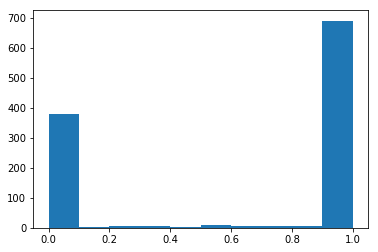

In [696]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
loanword_author_es_dominant_pct = loanword_author_query_dominant_subreddit_data.groupby('author').apply(lambda x: x[x.loc[:, 'dominant_lang']=='es'].shape[0] / x.shape[0])
plt.hist(loanword_author_es_dominant_pct)
plt.show()

OK! Very few people who cross-post, which makes the analysis easier.

Next test: are authors who tend to write in ES-dominant subreddits also more likely to use integrated verbs?

In [697]:
dominant_lang_pct_cutoff = 0.9
es_dominant_authors = loanword_author_es_dominant_pct[loanword_author_es_dominant_pct >= dominant_lang_pct_cutoff].index.tolist()
en_dominant_authors = loanword_author_es_dominant_pct[loanword_author_es_dominant_pct <= (1-dominant_lang_pct_cutoff)].index.tolist()
print('%d ES dominant authors'%(len(es_dominant_authors)))
print('%d EN dominant authors'%(len(en_dominant_authors)))

691 ES dominant authors
379 EN dominant authors


In [698]:
from scipy.stats import fisher_exact
es_dominant_integrated_verb_count = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'author'].isin(es_dominant_authors)].shape[0]
en_dominant_integrated_verb_count = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'author'].isin(en_dominant_authors)].shape[0]
es_dominant_light_verb_count = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'author'].isin(es_dominant_authors)].shape[0]
en_dominant_light_verb_count = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'author'].isin(en_dominant_authors)].shape[0]
contingency_table = [[es_dominant_light_verb_count, es_dominant_integrated_verb_count], 
                     [en_dominant_light_verb_count, en_dominant_integrated_verb_count]]
print(contingency_table)
odds_ratio, p_val = fisher_exact(contingency_table)
print('difference in odds is significant %.3f (p=%.3E)'%(odds_ratio, p_val))

[[412, 4907], [103, 1410]]
difference in odds is significant 1.149 (p=2.464E-01)


In [699]:
# let's give equal weight to all authors => deduplicate
loanword_integrated_verb_author_data_dedup = loanword_integrated_verb_author_data.drop_duplicates('author', inplace=False)
loanword_light_verb_author_data_dedup = loanword_light_verb_author_data.drop_duplicates('author', inplace=False)
es_dominant_integrated_verb_count = loanword_integrated_verb_author_data_dedup[loanword_integrated_verb_author_data_dedup.loc[:, 'author'].isin(es_dominant_authors)].shape[0]
en_dominant_integrated_verb_count = loanword_integrated_verb_author_data_dedup[loanword_integrated_verb_author_data_dedup.loc[:, 'author'].isin(en_dominant_authors)].shape[0]
es_dominant_light_verb_count = loanword_light_verb_author_data_dedup[loanword_light_verb_author_data_dedup.loc[:, 'author'].isin(es_dominant_authors)].shape[0]
en_dominant_light_verb_count = loanword_light_verb_author_data_dedup[loanword_light_verb_author_data_dedup.loc[:, 'author'].isin(en_dominant_authors)].shape[0]
contingency_table = [[es_dominant_light_verb_count, es_dominant_integrated_verb_count], 
                     [en_dominant_light_verb_count, en_dominant_integrated_verb_count]]
print(contingency_table)
odds_ratio, p_val = fisher_exact(contingency_table)
print('difference in odds is significant %.3f (p=%.3E)'%(odds_ratio, p_val))

[[212, 659], [73, 309]]
difference in odds is significant 1.362 (p=4.796E-02)


OK! The differences aren't significant for this subset.

What if we compute ES-dominant and EN-dominant posting tendency based on the total subreddit counts?

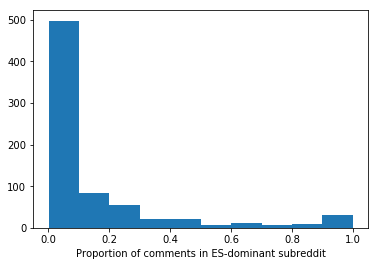

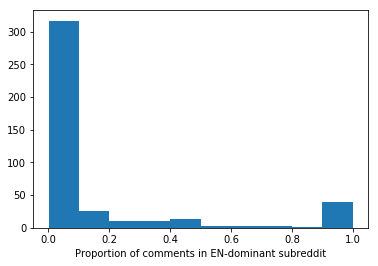

In [700]:
author_var = 'author'
loanword_author_subreddit_counts = loanword_author_query_author_subreddits_data.loc[:, 'author'].value_counts()
loanword_author_es_dominant_subreddit_counts = loanword_author_query_dominant_subreddit_data[loanword_author_query_dominant_subreddit_data.loc[:, 'dominant_lang']=='es'].loc[:, 'author'].value_counts()
loanword_author_en_dominant_subreddit_counts = loanword_author_query_dominant_subreddit_data[loanword_author_query_dominant_subreddit_data.loc[:, 'dominant_lang']=='en'].loc[:, 'author'].value_counts()
es_dominant_post_pct = (loanword_author_es_dominant_subreddit_counts / loanword_author_subreddit_counts.loc[loanword_author_es_dominant_subreddit_counts.index]).sort_values(inplace=False, ascending=False)
en_dominant_post_pct = (loanword_author_en_dominant_subreddit_counts / loanword_author_subreddit_counts.loc[loanword_author_en_dominant_subreddit_counts.index]).sort_values(inplace=False, ascending=False)
plt.hist(es_dominant_post_pct)
plt.xlabel('Proportion of comments in ES-dominant subreddit')
plt.show()
plt.hist(en_dominant_post_pct)
plt.xlabel('Proportion of comments in EN-dominant subreddit')
plt.show()

OK! Very few people post exclusively in the ES-dominant and EN-dominant forums.

In [701]:
dominant_subreddit_post_pct_cutoff = 0.5
authors_with_high_es_dominant_post_pct = es_dominant_post_pct[es_dominant_post_pct > dominant_subreddit_post_pct_cutoff].index.tolist()
authors_with_high_en_dominant_post_pct = en_dominant_post_pct[en_dominant_post_pct > dominant_subreddit_post_pct_cutoff].index.tolist()
print('%d authors with high-ES dominant posting'%(len(authors_with_high_es_dominant_post_pct)))
print('%d authors with high-EN dominant posting'%(len(authors_with_high_en_dominant_post_pct)))

63 authors with high-ES dominant posting
49 authors with high-EN dominant posting


In [702]:
from scipy.stats import fisher_exact
es_dominant_integrated_verb_count = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'author'].isin(authors_with_high_es_dominant_post_pct)].shape[0]
en_dominant_integrated_verb_count = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'author'].isin(authors_with_high_en_dominant_post_pct)].shape[0]
es_dominant_light_verb_count = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'author'].isin(authors_with_high_es_dominant_post_pct)].shape[0]
en_dominant_light_verb_count = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'author'].isin(authors_with_high_en_dominant_post_pct)].shape[0]
contingency_table = [[es_dominant_light_verb_count, es_dominant_integrated_verb_count], 
                     [en_dominant_light_verb_count, en_dominant_integrated_verb_count]]
print(contingency_table)
odds_ratio, p_val = fisher_exact(contingency_table)
print('difference in odds is significant %.3f (p=%.3E)'%(odds_ratio, p_val))

[[10, 115], [1, 15]]
difference in odds is significant 1.304 (p=1.000E+00)


OK! Even when considering `ES`-dominant using all posts to normalize, we see no significant difference.

Let's throw out the authors and just look at the aggregate posts to see if posts that occur in `ES`-dominant subreddits tend to have more integrated verbs than posts that occur in `EN`-dominant subreddits.

In [703]:
loanword_integrated_verb_es_dominant_subreddit_data = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'subreddit'].isin(es_en_dominant_subreddit_data[es_en_dominant_subreddit_data.loc[:, 'dominant_lang']=='es'].loc[:, 'subreddit'])]
loanword_integrated_verb_en_dominant_subreddit_data = loanword_integrated_verb_author_data[loanword_integrated_verb_author_data.loc[:, 'subreddit'].isin(es_en_dominant_subreddit_data[es_en_dominant_subreddit_data.loc[:, 'dominant_lang']=='en'].loc[:, 'subreddit'])]
loanword_light_verb_es_dominant_subreddit_data = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'subreddit'].isin(es_en_dominant_subreddit_data[es_en_dominant_subreddit_data.loc[:, 'dominant_lang']=='es'].loc[:, 'subreddit'])]
loanword_light_verb_en_dominant_subreddit_data = loanword_light_verb_author_data[loanword_light_verb_author_data.loc[:, 'subreddit'].isin(es_en_dominant_subreddit_data[es_en_dominant_subreddit_data.loc[:, 'dominant_lang']=='en'].loc[:, 'subreddit'])]
contingency_table = [
    [
        loanword_light_verb_es_dominant_subreddit_data.shape[0], loanword_integrated_verb_es_dominant_subreddit_data.shape[0], 
    ],
    [
        loanword_light_verb_en_dominant_subreddit_data.shape[0], loanword_integrated_verb_en_dominant_subreddit_data.shape[0]
    ]
                    ]
print(contingency_table)
odds_ratio, p_val = fisher_exact(contingency_table)
print('difference is significant with ratio = %.3f (p=%.3E)'%(odds_ratio, p_val))

[[32, 317], [1, 35]]
difference is significant with ratio = 3.533 (p=3.431E-01)


### Regression to predict light verb use
Let's try to predict light verb vs. integrated verb while controlling for effects by word, monolingual/bilingual user, subreddit posting history.

Features:
- word
- subreddit
- user language status (monolingual vs. bilingual)
- user post history (monolingual vs. bilingual vs. other subreddits)

In [706]:
print(loanword_light_verb_author_data.shape)
print(loanword_integrated_verb_author_data.shape)

(3362, 4)
(37878, 4)


In [711]:
# add monolingual/bilingual author status: bilingual (25-75% of posts in ES), monolingual (75%+ of posts in ES), other
# add subreddit posting history: EN-subreddit posting (75%+ of posts in EN-aligned subreddits), ES-subreddit posting (75%+ of posts in ES-aligned subreddits), other
display(loanword_author_query_author_subreddits_data.head())

,author,subreddit,lang
0,All-Your-Base,chile,es
1,All-Your-Base,chile,es
2,All-Your-Base,chile,es
3,All-Your-Base,chile,es
4,All-Your-Base,chile,es


In [755]:
import os
import re
from functools import reduce
## get subreddit lang counts
subreddit_data_dir = '../../data/mined_reddit_comments/'
subreddit_lang_count_file_matcher = re.compile('RC_20[0-9]{2}-\d{2}_subreddit_lang_counts.tsv')
subreddit_lang_count_files = [os.path.join(subreddit_data_dir, x) for x in os.listdir(subreddit_data_dir) if subreddit_lang_count_file_matcher.search(x) is not None]
subreddit_lang_counts_combined = reduce(lambda x,y: x.add(y, fill_value=0), subreddit_lang_counts).fillna(0)
subreddit_lang_counts_combined.fillna(0, inplace=True)
subreddit_lang_counts_sum = subreddit_lang_counts_combined.sum(axis=1)
# remove users?
user_matcher = re.compile('^u_')
valid_subredit_idx = list(filter(lambda x: user_matcher.search(x) is None, subreddit_lang_counts_combined.index))
subreddit_lang_counts_combined = subreddit_lang_counts_combined.loc[valid_subredit_idx, :]
# normalize
subreddit_lang_pct = subreddit_lang_counts_combined.apply(lambda x: x / x.sum(), axis=1)
## compute ES percent per subreddit
subreddit_es_pct = subreddit_lang_pct.loc[:, 'es']

In [763]:
def assign_author_subreddit_history(author_history_data, subreddit_lang_data, 
                                    subreddit_monolingual_cutoff=0.75, 
                                    subreddit_bilingual_cutoff=[0.25, 0.75]):
    """
    Assign history label to each author based on subreddits visited:
    "Monolingual history" == >50% comments in monolingual subreddits (>=75% lang)
    "Bilingual history" == >50% comments in bilingual subreddits (25%<X<75% lang)
    "Other" == otherwise
    """
    monolingual_subreddits = subreddit_lang_data[subreddit_lang_data >= subreddit_monolingual_cutoff].index.tolist()
    bilingual_subreddits = subreddit_lang_data[(subreddit_lang_data > subreddit_bilingual_cutoff[0]) & 
                                               (subreddit_lang_data < subreddit_bilingual_cutoff[1])].index.tolist()
    author_subreddit_history = author_history_data.loc[:, ['author', 'subreddit']]
    subreddit_history_label_cutoff = 0.50
    author_history_data_labels = []
    for author_i, data_i in author_history_data.groupby('author'):
        N_i = data_i.shape[0]
        monolingual_subreddit_pct = data_i[data_i.loc[:, 'subreddit'].isin(monolingual_subreddits)].shape[0] / N_i
        bilingual_subreddit_pct = data_i[data_i.loc[:, 'subreddit'].isin(bilingual_subreddits)].shape[0] / N_i
        if(monolingual_subreddit_pct > subreddit_history_label_cutoff):
            subreddit_history_label_i = 'monolingual'
        elif(bilingual_subreddit_pct > subreddit_history_label_cutoff):
            subreddit_history_label_i = 'bilingual'
        else:
            subreddit_history_label_i = 'other'
        author_history_data_labels.append([author_i, subreddit_history_label_i])
    author_history_data_labels = pd.DataFrame(author_history_data_labels, columns=['author', 'subreddit_history'])
    return author_history_data_labels

In [765]:
author_history_data = assign_author_subreddit_history(loanword_author_query_author_subreddits_data, subreddit_es_pct)
display(author_history_data.head())
print(author_history_data.loc[:, 'subreddit_history'].value_counts())

,author,subreddit_history
0,--L-E-D--,other
1,--Quartz--,monolingual
2,--Satan--,other
3,--VladimirPudding--,monolingual
4,--dude-,other


monolingual    7205
other          2874
bilingual      1658
Name: subreddit_history, dtype: int64


In [766]:
def assign_author_lang_status(author_history_data, lang='es', monolingual_cutoff=0.75, bilingual_cutoff=[0.25, 0.75]):
    """
    Assign author lang status:
    "Monolingual" == author writes >= 75% of posts in lang
    "Bilingual" == author writes 25<X<75% of posts in lang
    """
    author_lang_status = []
    for author_i, data_i in author_history_data.groupby('author'):
        N_i = data_i.shape[0]
        author_lang_pcts_i = data_i.loc[:, 'lang'].value_counts() / N_i
        lang_pct_i = author_lang_pcts_i.loc[lang]
        if(lang_pct_i >= monolingual_cutoff):
            lang_status_i = 'monolingual'
        elif(lang_pct_i > bilingual_cutoff[0] and lang_pct_i < bilingual_cutoff[1]):
            lang_status_i = 'bilingual'
        else:
            lang_status_i = 'other'
        author_lang_status.append([author_i, lang_status_i])
    author_lang_status = pd.DataFrame(author_lang_status, columns=['author', 'lang'])
    return author_lang_status

In [767]:
author_lang_status_data = assign_author_lang_status(loanword_author_query_author_subreddits_data, lang='es')
display(author_lang_status_data.head())
print(author_lang_status_data.loc[:, 'lang'].value_counts())

,author,lang
0,--L-E-D--,monolingual
1,--Quartz--,monolingual
2,--Satan--,monolingual
3,--VladimirPudding--,monolingual
4,--dude-,monolingual


monolingual    11737
Name: lang, dtype: int64


TODO: regression to control for loanword effects, monolingual/bilingual effects

TODO: compute `ES`/`EN` using matched pairs of subreddits, e.g. all authors who tend to post more often in `r/gaming` than in `r/VideoJuegos`.

### Old code

In [668]:
# get min/max date
from elasticsearch import Elasticsearch
es = Elasticsearch(timeout=100)
index_name = 'twitter_posts_2018_m_10_12'
es_query = {
    "aggs" : {
        "date" : {
            "max" : {
                "field" : "created_at"
            }
        }
    },
    "size" : 0
}
res = es.search(index=index_name, body=es_query)
print(res['aggregations']['date'])

{'value': 1538294018000.0, 'value_as_string': '2018-09-30T07:53:38.000Z'}


In [566]:
## testing scan
from elasticsearch.helpers import scan
loanword_noun = 'post'
loanword_verb_phrase = '(hacer|hago) (un )?%s'%(loanword_noun)
loanword_verb_phrase_matcher = re.compile(loanword_verb_phrase)
tmp_es_query = {
    "query" : {
        "bool" : {
            # one-word match
            "must" : [
                {
                    "match" : {
                        "body" : integrated_verb,
                    }
                },
                {
                    "match" : {
                        "lang" : "es"
                    }
                }
            ],
        }
    }
}
es = Elasticsearch(timeout=100)
res = scan(es, index=es_instance_name, query=tmp_es_query)
for i, res_i in enumerate(res):
#     print(res_i)
#     if(i > 100):
#         break
#     if(res_i['_source']['author'] not in bot_authors):
    if(loanword_verb_phrase_matcher.search(res_i['_source']['body']) is not None):
        print(res_i['_source']['body'])
        break

KeyError: 'skipped'

In [ ]:
## TODO: how to do nested aggregation without memory error??
from elasticsearch import Elasticsearch
from data_helpers import collect_scroll_results
# nested aggregation for subreddit/lang counts
PARTITIONS=10
ES_MAX_SEARCH_SIZE=20
nested_agg_query = {
    "aggs" : {
        "subreddit" : {
            "terms" : {
                "field" : "subreddit",
#                     "field" : "lang"
                "include": {
                   "partition": 0,
                   "num_partitions": PARTITIONS
                },
                "size" : ES_MAX_SEARCH_SIZE,
            },
            "aggs" : {
                "lang" : {
                    "terms" : {
                        "field" : "lang"
                    }
                }
            }
        }
    }
}
es_cluster_name = 'reddit_comments'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'june', 'july', 'aug', 'sep', 'oct', 'nov', 'dec']
es_dir = '/hg190/elastic_search/es_instances_for_reddit_comments/'
es_year = 2018
es_start_month = 7
es_end_month = 9
es_instance_name = '%s_%d_m_%d_%d'%(es_cluster_name, es_year, es_start_month, es_end_month)
es_start_month_str = months[es_start_month-1]
es_end_month_str = months[es_end_month-1]
es_dir_full = os.path.join(es_dir, str(es_year), '%s-%s-%d'%(es_start_month_str, es_end_month_str, es_year), 'elasticsearch-2.1.1/bin')
print('starting index %s'%(es_instance_name))
# start up ES
es_command = './elasticsearch --cluster.name %s --node.name %s'%(es_cluster_name, es_instance_name)
#     try:
process = subprocess.Popen(es_command.split(' '), cwd=es_dir_full)
try:
    sleep(ES_INITIALIZE_TIMEOUT)
except Exception as e:
    pass
es_instance_name = "reddit_comments_%d_m_%d_%d"%(es_year, es_start_month, es_end_month)
# start index
es = Elasticsearch(timeout=180)
## TODO: scan, aggregate all results FORALL instances
try:
    nested_agg_results = es.search(index=es_instance_name, body=nested_agg_query, size=ES_MAX_SEARCH_SIZE)
except Exception as e:
    print(e)
# nested_agg_results = collect_scroll_results(es, es_instance_name, nested_agg_query)
process.terminate()